# Automated Correlation-Based Stock Classification with Machine Learning Forecasting

### Project Summary

A comprehensive Python-based system that automatically classifies stocks into correlation-based groups and applies machine learning models for price forecasting. The project incorporated extensive research and testing of multiple correlation methodologies including Pearson, Spearman, EWMA, Rolling Window, Kendall Tau, Partial Correlation, Distance Correlation, Mutual Information, and Copula-Based correlation to determine the optimal approach for financial time series analysis.

Through systematic evaluation, EWMA (Exponentially Weighted Moving Average) correlation was selected as the primary methodology due to its superior ability to weight recent market data more heavily while maintaining computational efficiency in volatile market conditions.

The platform processes 200+ stock tickers with complete daily historical data using the yfinance API, with scalable architecture designed to handle significantly larger datasets. The correlation engine dynamically groups stocks based on configurable minimum correlation thresholds, enabling flexible analysis across different market conditions and sectors.

Following comprehensive research and comparative testing of machine learning approaches including Neural Networks, Long Short-Term Memory (LSTM) networks, Recurrent Neural Networks (RNN), Random Forest, Support Vector Machines (SVM), Gradient Boosting methods, and Time Series Transformers, the system implements the optimal forecasting model selected based on performance metrics.

Through systematic evaluation, _______ was selected as the primary forecasting methodology due to its superior performance in [specific reasons to be filled based on testing results].

Built with a robust technology stack including Python, pandas, numpy, scikit-learn, PyTorch, and matplotlib for data processing, statistical analysis, machine learning implementation, and visualization. The system emphasizes statistical rigor and quantitative analysis while eliminating human bias from stock classification and prediction processes. Comprehensive performance metrics and backtesting capabilities validate model effectiveness across various market conditions.

**Status:** In active development with correlation analysis complete and ML forecasting module in progress.<br>
**Author:** Nicholas Taylor <br>
**Date:** 2025-06

## imports <a id="import"></a>



In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from win32api import mouse_event

import utils.machine_learning as ml
import seaborn as sns
import datetime as dt
import utils.ticker_manipulation as tm
#import utils.correlations as cor
import utils.grouping as grouping
import utils.visualisations as vis
import csv
import utils.timing as timing
import random
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

##

In [2]:
ticker_list = ['KO', 'MDB', 'BAC', 'BLK', 'SYK', 'MRK', 'AAL', 'PINS', 'LOW', 'DAL', 'SHW', 'LLY', 'ASML', 'UNH', 'PSX', 'CRM', 'HSY', 'AFRM', 'CHTR', 'PCAR', 'DECK', 'SPGI', 'RHHBY', 'SHOP', 'WFC', 'CVX', 'ABBV', 'BMY', 'AEP', 'PYPL', 'JNJ', 'AXP', 'NVS', 'YUM', 'MSCI', 'ECL', 'MDLZ', 'HCA', 'SBUX', 'UAL', 'CHD', 'KMI', 'XOM', 'CVS', 'GILD', 'HLT', 'QSR', 'LHX', 'GOOGL', 'SLB', 'DDOG', 'VWAGY', 'EQNR', 'AMD', 'VALE', 'COST', 'AMAT', 'GE', 'WMT', 'NVDA', 'NOW', 'TCEHY', 'D', 'COP', 'JD', 'ELV', 'IQV', 'CBOE', 'RIO', 'SAP', 'SCHW', 'LYV', 'TDOC', 'NEE', 'SO', 'ROST', 'MKC', 'STLD', 'CRWD', 'MS', 'DVN', 'PCG', 'HON', 'APD', 'GS', 'REGN', 'KHC', 'INFY', 'BIDU', 'SRE', 'TTE', 'CSCO', 'NET', 'CMCSA', 'ADDYY', 'MAR', 'NFLX', 'SNOW', 'CZR', 'APA', 'GM', 'SNAP', 'NDAQ', 'META', 'NUE', 'EW', 'VLO', 'VRTX', 'HES', 'AZN', 'MSFT', 'BA', 'ADBE', 'SPOT', 'V', 'BHP', 'CCL', 'BSX', 'NTES', 'BKNG', 'TSLA', 'LMT', 'ZS', 'K', 'F', 'TJX', 'SKX', 'T', 'SEDG', 'BEP', 'SPWR', 'DOW', 'NOC', 'IBM', 'UL', 'BYD', 'LCID', 'TM', 'ETN', 'LVMUY', 'MCD', 'WYNN', 'CLX', 'C', 'PENN', 'DUK', 'FI', 'BABA', 'WBD', 'AMGN', 'ENPH', 'ADSK', 'EL', 'AVGO', 'RCL', 'MA', 'DG', 'SHEL', 'LIN', 'X', 'QCOM', 'TMO', 'PEG', 'MPC', 'OXY', 'EMR', 'DD', 'FCX', 'HD', 'CL', 'RTX', 'PPG', 'GPN', 'MDT', 'INTU', 'GD', 'FANG', 'ETSY', 'AAPL', 'WMB', 'PM', 'ROKU', 'INTC', 'ZBH', 'TSM', 'CAT', 'PFE', 'LRCX', 'VZ', 'RIVN', 'MGM', 'ACN', 'DOV', 'HRL', 'CMI', 'MU', 'KLAC', 'PARA', 'DPZ', 'KMB', 'PLTR', 'DE', 'ICE', 'BP', 'AMZN', 'DLTR', 'AA', 'PG', 'FSLR', 'ABNB', 'OKTA', 'GIS', 'TDG', 'EIX', 'UBER', 'DOCU', 'EXC', 'DIS', 'UAA', 'TGT', 'WIT', 'ISRG', 'ED', 'HAL', 'PEP', 'WDAY', 'RUN', 'EPAM', 'BKR', 'LYFT', 'TMUS', 'PDD', 'NKE', 'ORCL', 'NEM', 'JPM', 'LULU', 'PANW', 'MO', 'EOG', 'FTNT', 'MRNA', 'IR', 'CME', 'ULTA', 'LYB', 'EQIX']

test_tickers=['ASML', 'AMAT', 'LRCX', 'KLAC','COP', 'DVN', 'APA', 'FANG', 'EOG']

# Config
*start_date* is the day it starts tracking stock values from <br>
*end_date* is the day it ends tracking stock values on <br>

*ewma_span* is the estimated waited mean value which is the decay of the  weighted mean value higher  value is a lower decay<br>
(Common values: 20 (approx. 1 month), 60 (approx. 3 months))

*grouping_minimum_correlation* is the correlation value required to group 2 stocks <br>

In [3]:
#Config

#list dates to map for
start_date = "2020-01-01"
#end_date = "2025-07-12"
end_date=dt.datetime.now().strftime("%Y-%m-%d")
# --- EWMA Configuration ---
# 'span' determines the decay. A smaller span means faster decay and more weight to recent data.
# Common values: 20 (approx. 1 month), 60 (approx. 3 months).
ewma_span = 720 # You can adjust this value based on how much you want to prioritize recent data

#minimum correlation required for any value to be added to a group
#can be between it and any value in the group, does not require all values
grouping_minimum_correlation=0.80


## Data retrieval
This function fetches all the required data from the yfinance API and writes it to the all_dict dictionary, storing the stock tickers as keys and the stock close prices as values
We are using the timer_function to measure time taken for scalability

In [4]:
time,all_dict=timing.timer_function(lambda: tm.get_tickers_data(test_tickers,start_date,end_date))
print(f"time taken:{time}")

time taken:4.340509414672852


## Data Visualisation
This function plots the close prices of each ticker on a matplotlib graph <br>
_function is found in visualisations.py_


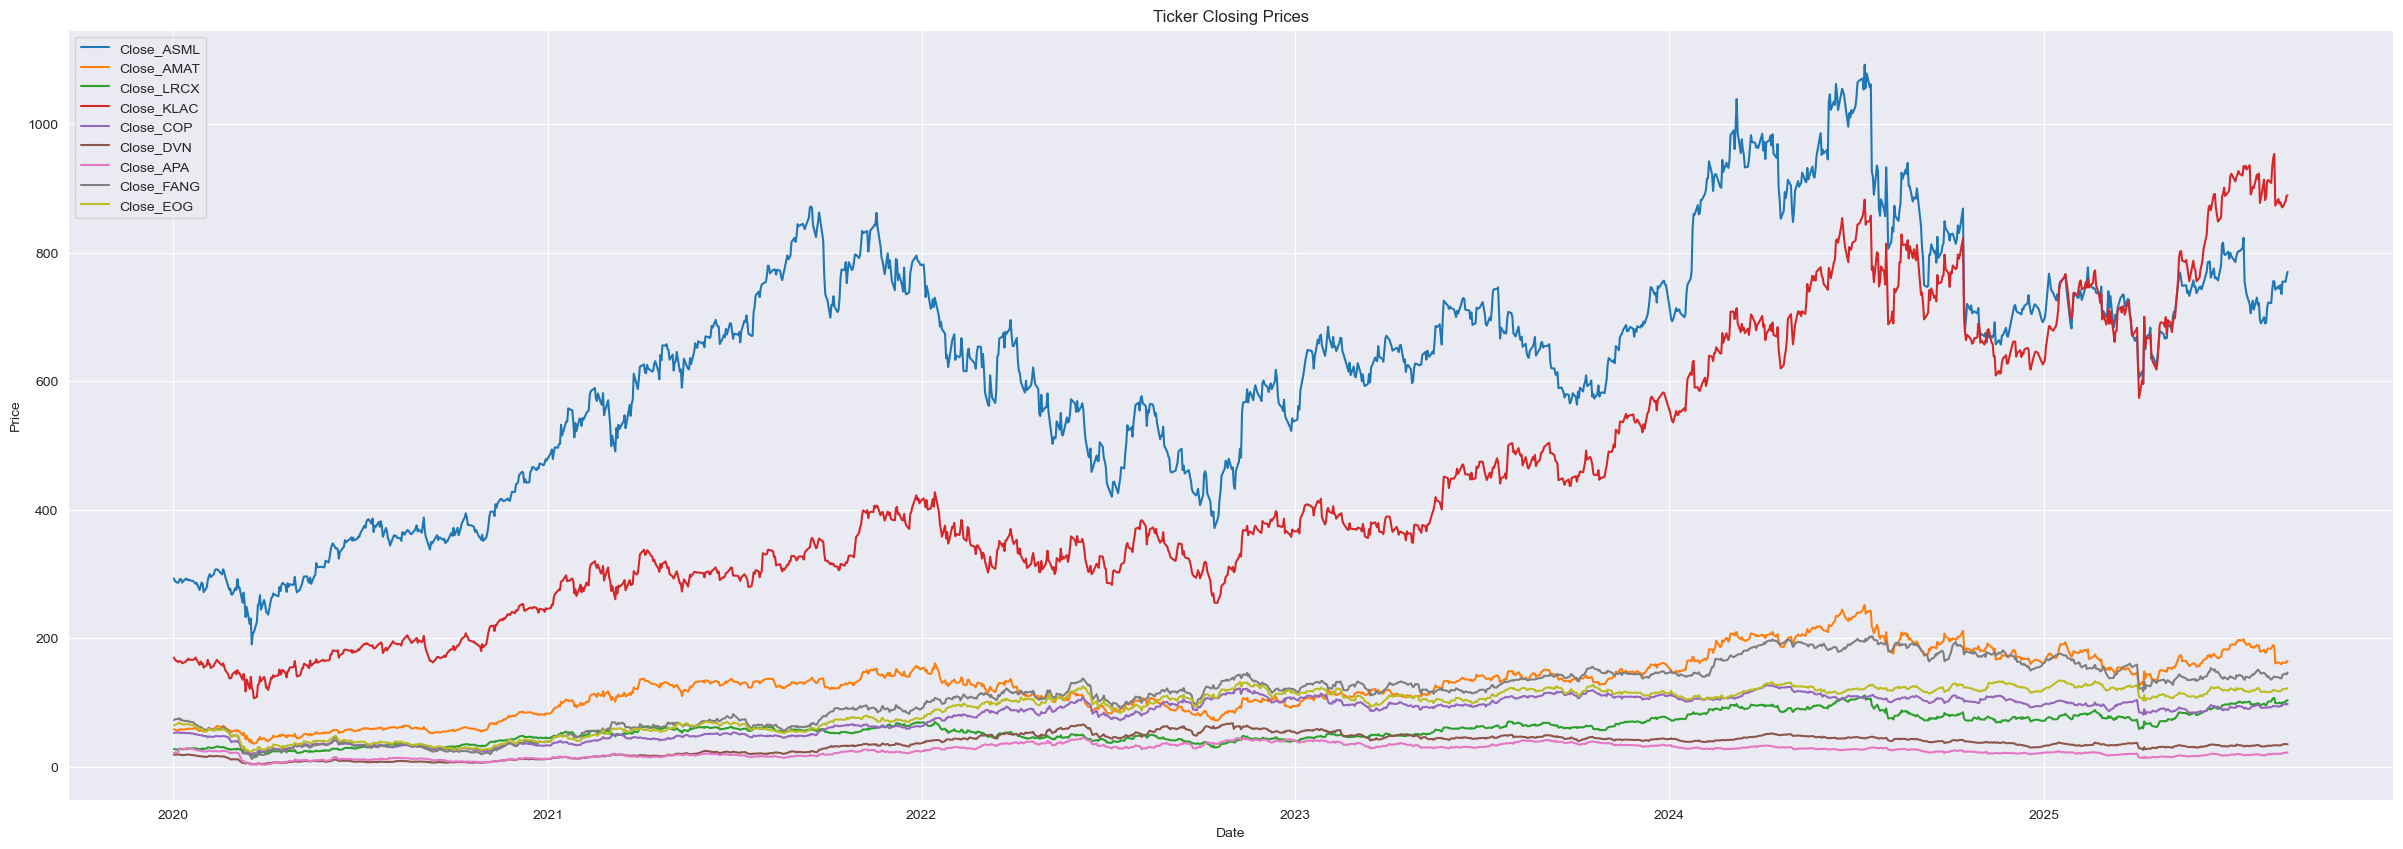

In [5]:
vis.plot_tickers_values(all_dict)

This function plots the returns calculated from close prices of each ticker on a matplotlib graph <br>
_function is found in visualisations.py_

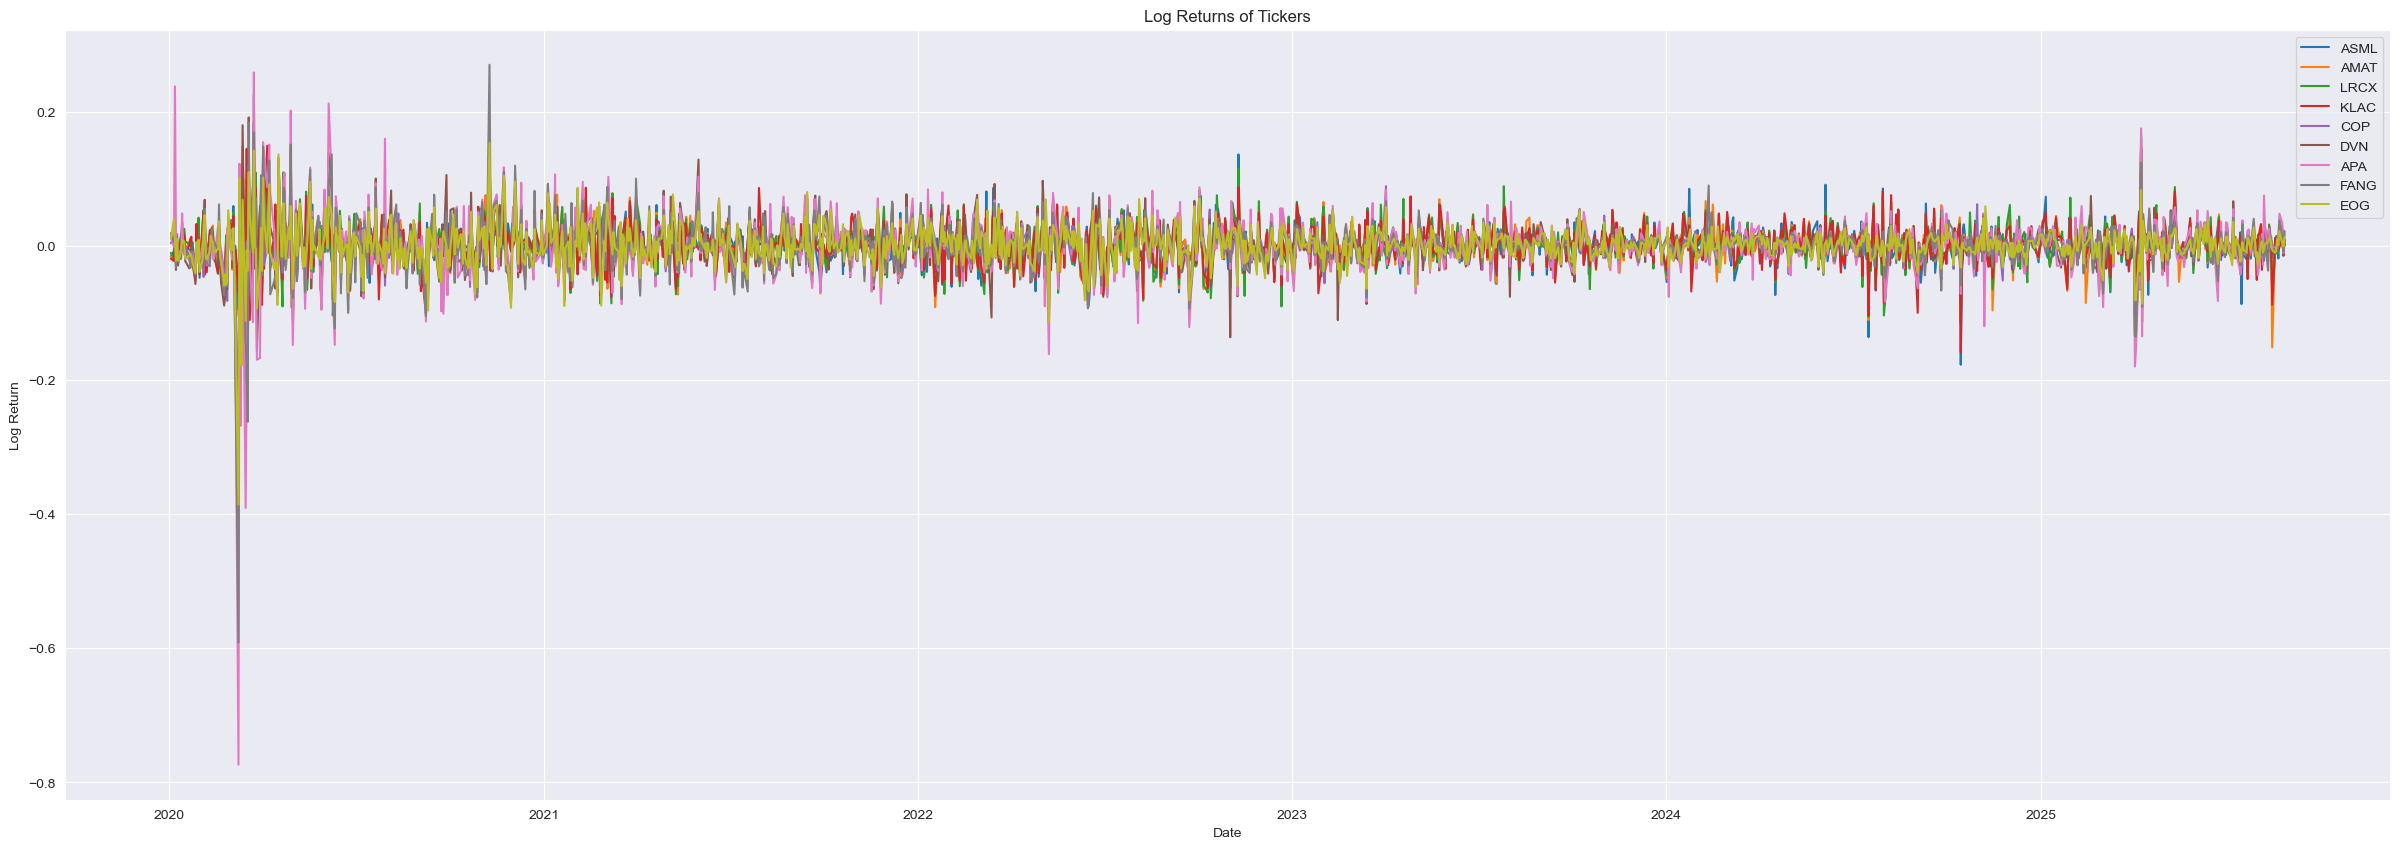

In [6]:
df_returns=vis.plot_tickers_return(all_dict)

## Exploring Correlation Methods

### Pearson Correlation
Linear correlation that measures the strength and direction of a linear relationship between two variables.<br>
**Use in stocks:** Not ideal on its own; it gives equal weight to all data points, so it doesn’t capture recent dynamics or handle outliers well.

---
### Spearman Correlation
Rank-based correlation that assesses how well the relationship between two variables can be described using a monotonic function.<br>
**Use in stocks:** More robust to outliers and useful for capturing consistent directional relationships, even if not linear.

---
### EWMA Correlation
Exponentially Weighted Moving Average correlation that gives more weight to recent data points.<br>
**Use in stocks:** Very useful for tracking changing relationships over time, especially in volatile markets.

---
### Rolling Window Correlation
Computes correlation over a sliding window of time, capturing localized relationships.<br>
**Use in stocks:** Good for observing short-term changes in correlation, particularly useful in backtesting strategies.

---
### Additional Methods Explored

**Kendall Tau Correlation** – Rank-based correlation like Spearman but with a different calculation; slower and more niche, useful for small datasets.<br>
**Partial Correlation** – Measures the relationship between two variables while controlling for others; useful when filtering out confounding effects.<br>
**Distance Correlation** – Captures both linear and nonlinear relationships; detects hidden dependencies but not limited to -1 to 1 range.<br>
**Mutual Information** – Measures how much information one variable gives about another; useful in machine learning and nonlinear analysis.<br>
**Copula-Based Correlation** – Captures dependency structures in the tails of distributions; valuable for modeling extreme events and risk.

-------------------------------------------------------------------------------------------
### Choice: EWMA Correlation
The choice of correlation method is the Exponentially Weighted Moving Average, this has been chosen as we are working with time series data where more recent values have a larger affect then older values on the market. EWMA Correlation is less computationally expensive as it follows linear time complexity, O(n) due to a single pass through the data, and requires less memory than Rolling Window Correlation as it only requires storing the most recent correlation value.

In [7]:
# --- Calculate Exponentially Weighted Moving Average (EWMA) Correlation Matrix ---
# This gives more weight to recent values.
# The `span` parameter determines the decay rate.
# .corr() on the EWM object computes the EWMA correlation matrix.
# We then take the last complete correlation matrix from the multi-indexed result.
time, ewma_corr_df = timing.timer_function(lambda: (df_returns.ewm(span=ewma_span).corr()))

# Get the most recent EWMA correlation matrix
# df_returns.index[-1] gets the last date in your returns DataFrame.
correlation_matrix = ewma_corr_df.xs(df_returns.index[-1], level=0)
print(f"time taken: {time}")

time taken: 0.025997638702392578


## Visualising correlation using a heatmap
This function plots a heatmap comparing the correlation of all the given stock tickers. <br>
_function is found in visualisations.py_

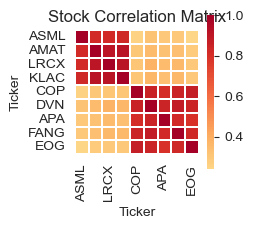

In [8]:
vis.heatmap_correlations(correlation_matrix)

## Exploring Grouping Methods

### All Grouping

Groups stocks where every stock correlates with every other stock in the group above the minimum threshold.

- **Use in stocks:** Creates tight, high-quality clusters; ideal for identifying stocks that move together consistently.
- **Complexity:** O(n³) theoretical, but often faster in practice
- **Best for:** High-quality sector clusters, risk management, pair trading

---

### Any Grouping

Groups stocks where each stock correlates with at least one other stock in the group above the minimum threshold.

- **Use in stocks:** Fast initial grouping for broad sector identification
- **Complexity:** O(n² × g) where g is average group size
- **Best for:** Initial broad categorization, sector discovery

---

### Additional Grouping Methods

- **Hierarchical Clustering** – Bottom-up, slower but more precise
- **HUB Correlation** – main stock with correlations, can be inaccurate.
- **K-Means Clustering** – Partitioning-based; requires number of clusters
- **DBSCAN Clustering** – Density-based; finds outliers
- **Graph-Based Clustering** – Uses correlation as edges in a graph
- **Dynamic Time Warping** – Groups by shape similarity; great for time-lagged trends

___
### Choice: ALL Correlation Grouping
The choice of grouping method is ALL Correlation, selected for its superior performance characteristics: <br>
**Quality over quantity**: Creates tighter, more reliable groups where every stock genuinely correlates with every other stock, ensuring group coherence. <br>
**Unexpected performance advantage**: Despite O(n³) complexity, proves faster in practice due to early elimination of unsuitable stocks and smaller resulting group sizes. <br>
**Risk management benefits**: High-quality groups are more reliable for portfolio construction and risk assessment, as correlation relationships are verified across all pairs. <br>
**Computational efficiency**: Early rejection mechanism and smaller groups reduce overall computational overhead compared to methods that create large, loosely-connected groups requiring extensive validation. <br>



In [9]:
# Get results from both methods
time_any,final_groups_any = timing.timer_function(lambda: grouping.grouping_any_correlation(grouping_minimum_correlation, correlation_matrix, 3))
time_all,final_groups_all = timing.timer_function(lambda: grouping.grouping_all_correlate(grouping_minimum_correlation, correlation_matrix, 3))

def print_groups_with_names(groups,group_names,time):
    print("\n",group_names,"(time taken: ", time,")")
    print("="*30)
    if not groups:
        print("   No groups found with current parameters.\n")
        return

    for i, group in enumerate(groups, 1):
        print(f"\n Stock Group {i} ({len(group)} stocks):")
        print("-" * 30)

        for ticker in group:
            try:
                company_name = yf.Ticker(ticker).info.get('longName', 'Name not available')
                print(f"   {ticker:6} = {company_name}")
            except:
                print(f"   {ticker:6} = [Error retrieving name]")
        print()

# Display results for each method
print_groups_with_names(final_groups_any, "ANY Correlation", time_any)
print_groups_with_names(final_groups_all, "ALL Correlate",time_all)

final_groups = final_groups_all


 ANY Correlation (time taken:  0.0 )

 Stock Group 1 (4 stocks):
------------------------------
   ASML   = ASML Holding N.V.
   AMAT   = Applied Materials, Inc.
   LRCX   = Lam Research Corporation
   KLAC   = KLA Corporation


 Stock Group 2 (5 stocks):
------------------------------
   COP    = ConocoPhillips
   DVN    = Devon Energy Corporation
   APA    = APA Corporation
   FANG   = Diamondback Energy, Inc.
   EOG    = EOG Resources, Inc.


 ALL Correlate (time taken:  0.0 )

 Stock Group 1 (4 stocks):
------------------------------
   ASML   = ASML Holding N.V.
   AMAT   = Applied Materials, Inc.
   LRCX   = Lam Research Corporation
   KLAC   = KLA Corporation


 Stock Group 2 (4 stocks):
------------------------------
   COP    = ConocoPhillips
   DVN    = Devon Energy Corporation
   APA    = APA Corporation
   FANG   = Diamondback Energy, Inc.



### Plotting groups:
this code plots all the automatically created groups in order to visualise the groups, this includes a group average price line which is the for each group which is an average return of the group.
This visualisation is not intuitable as we are plotting the group based on their value returns, yet grouping based on there percentage returns, this is showing how the stocks move in similar ways.
The text following each image is the correlation of each stock against the average of the rest of the stocks this a measure of how similarly the stocks move together, the final line is the intergroup correlation which is the correlation of the all the stocks in the group.

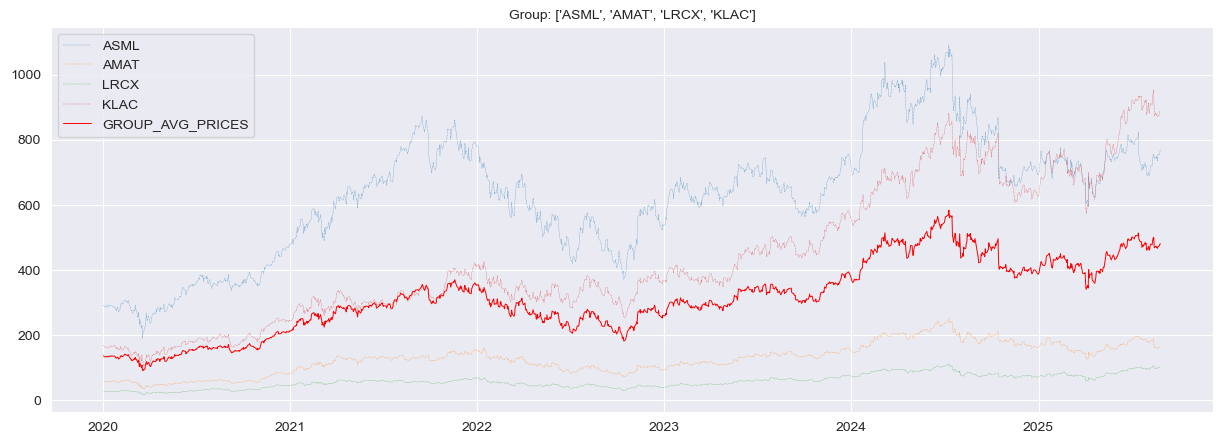

returns correlations:
KLAC vs GROUP_EWM_AVG (excluding KLAC): 0.937,  KLA Corporation
LRCX vs GROUP_EWM_AVG (excluding LRCX): 0.995,  Lam Research Corporation
AMAT vs GROUP_EWM_AVG (excluding AMAT): 0.998,  Applied Materials, Inc.
ASML vs GROUP_EWM_AVG (excluding ASML): 0.941,  ASML Holding N.V.

intergroup correlation: 0.86730


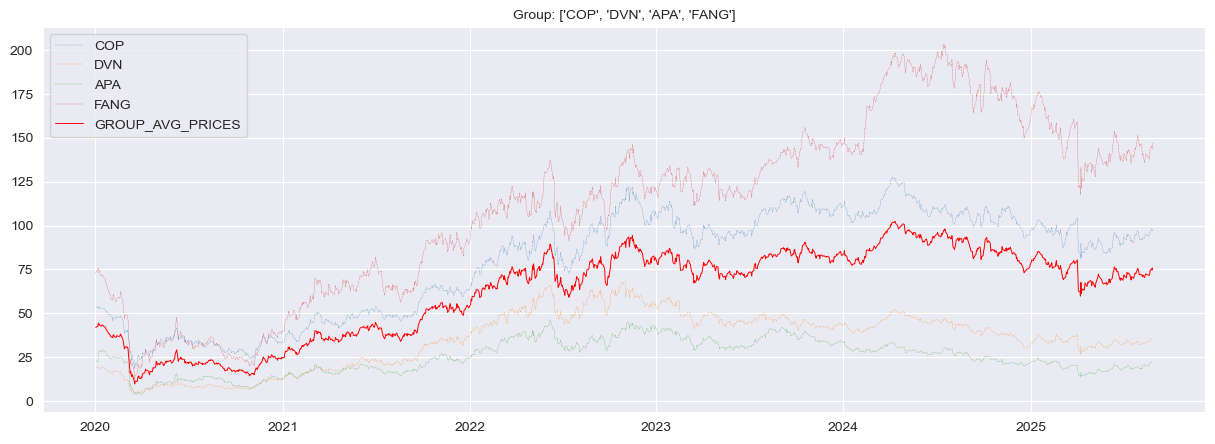

returns correlations:
FANG vs GROUP_EWM_AVG (excluding FANG): 0.963,  Diamondback Energy, Inc.
APA vs GROUP_EWM_AVG (excluding APA): 0.915,  APA Corporation
DVN vs GROUP_EWM_AVG (excluding DVN): 0.949,  Devon Energy Corporation
COP vs GROUP_EWM_AVG (excluding COP): 0.997,  ConocoPhillips

intergroup correlation: 0.84313


In [14]:
for group in final_groups:
    #Plot individual and average prices
    group_closes = vis.plot_group_prices_with_avg(group, all_dict)

    #EWMA-based correlation
    vis.print_ewma_correlations(group, group_closes, ewma_span)

    #Pairwise correlation from precomputed matrix
    group_corr_matrix = correlation_matrix.loc[group, group]

    avg_corr = group_corr_matrix.where(np.triu(np.ones_like(group_corr_matrix, dtype=bool), k=1)).stack().mean()
    print(f"intergroup correlation: {avg_corr:.5f}")

ASML returns: mean: 0.068% +/- std: 2.735%
AMAT returns: mean: 0.072% +/- std: 2.967%
LRCX returns: mean: 0.093% +/- std: 3.079%
KLAC returns: mean: 0.116% +/- std: 2.903%


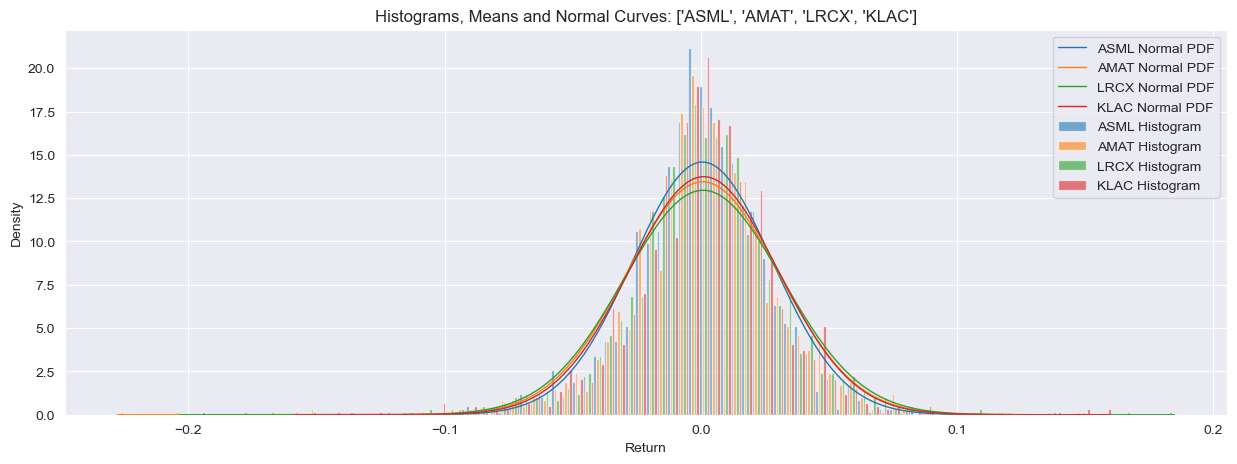

COP returns: mean: 0.043% +/- std: 2.744%
DVN returns: mean: 0.044% +/- std: 3.642%
APA returns: mean: 0.001% +/- std: 4.578%
FANG returns: mean: 0.049% +/- std: 3.737%


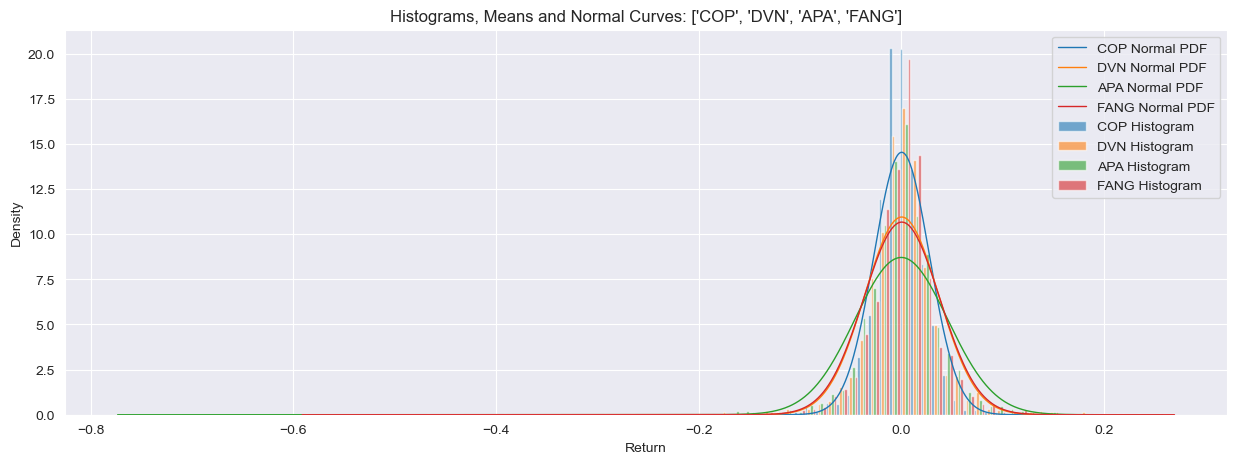

In [11]:
vis.plot_stock_distributions(final_groups_all,df_returns)

## What is available:
- **_final_groups_**: list of lists of stocks in correlated groups
- **_all_dict_**: dictionary of all the stocks values, with their tickers as keys
- **_df_returns_**: dictionary of all the return percentage values, with their tickers as keys

In [12]:
print(final_groups)
#print(all_dict.keys())
#print(df_returns.keys())

[['ASML', 'AMAT', 'LRCX', 'KLAC'], ['COP', 'DVN', 'APA', 'FANG']]



# Machine Learning Testing
## Testing Method
---
We will use a walk forward approach to testing these different prediction models to test real world accuracy for these predictions



In [13]:
stop # this is to not run the ml while testing other featurestures
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor  # Example model - replace with your actual model

for group in final_groups:
    # 1. Build feature matrix using all stocks in the group
    X = pd.concat([df_returns[ticker] for ticker in group], axis=1)
    X.columns = group  # Label columns with ticker names

    # 2. Get closing prices for the group to calculate average return
    group_returns = pd.DataFrame({ticker: df_returns[ticker] for ticker in group})

    # 3. Calculate group average return and shift to get next-day return
    y = group_returns.mean(axis=1).shift(-1)

    # 4. Drop rows with NaNs (from pct_change and shift)
    valid_idx = (~X.isnull().any(axis=1)) & (~y.isnull())
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    # 5. Initialize your model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # 6. Create walk-forward predictor
    wf_predictor = ml.WalkForwardPredictor(
        model=model,
        min_train_size=10,
        retrain_frequency=1
    )

    # 7. Run walk-forward prediction
    print(f"\nStarting walk-forward analysis for group: {', '.join(group)}")
    predictions, actuals, dates = wf_predictor.predict_and_learn(X, y)

    # 8. Plot results using one sample stock just for visual reference
    ml.plot_walkforward_results(wf_predictor, all_dict[group[0]]['Close'], target_stock="avg for group")

    # 9. Analyze performance
    performance_metrics = ml.analyze_walkforward_performance(wf_predictor)

    # 10. Create detailed comparison table
    comparison_df = pd.DataFrame({
        'Date': wf_predictor.prediction_dates,
        'Actual_Return': wf_predictor.actual_values,
        'Predicted_Return': wf_predictor.predictions,
        'Error': wf_predictor.errors,
        'Abs_Error': np.abs(wf_predictor.errors)
    })

    #print("\nFirst 10 predictions:")
    #print(comparison_df.head(10).round(6))
    #print("\nLast 10 predictions:")
    #print(comparison_df.tail(10).round(6))

NameError: name 'stop' is not defined